importing required libaries

In [20]:
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import jax
import jax.numpy as jnp
import haiku as hk
random.seed(0)
np.random.seed(0)
from jax import jacrev
import functools
import optax
import deepchem
from deepchem.models import PINNModel
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import deepchem as dc

defining the function

In [32]:
def pre_process_shock_data(N_u, N_f, t, x, Exact):


  X, T = np.meshgrid(x,t)

  X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
  u_star = Exact.flatten()[:,None] #flatten do the multidimesional array to the single dimensional array

               

  # boundary value condition
  lb = X_star.min(0)
  ub = X_star.max(0)    

  xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
  uu1 = Exact[0:1,:].T
  xx2 = np.hstack((X[:,0:1], T[:,0:1]))
  uu2 = Exact[:,0:1]
  xx3 = np.hstack((X[:,-1:], T[:,-1:]))
  uu3 = Exact[:,-1:]

  X_u_train = np.vstack([xx1, xx2, xx3])
  X_f_train = lb + (ub-lb)*lhs(2, N_f)
  X_f_train = np.vstack((X_f_train, X_u_train))
  u_train = np.vstack([uu1, uu2, uu3])
  idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
  X_u_train = X_u_train[idx, :]
  u_train = u_train[idx,:]
  return X_u_train, u_train, X_f_train, X_star, (X, T)
 
 

mat_data = scipy.io.loadmat(os.path.join(os.getcwd(), 'data/burgers_shock.mat'))
                            

N_u = 100
N_f = 10000

t = mat_data['t'].flatten()[:,None]
x = mat_data['x'].flatten()[:,None]
Exact = np.real(mat_data['usol']).T

labeled_X, labeled_y, unlabeled_X, full_domain, meshgrid = pre_process_shock_data(N_u, N_f, t, x, Exact)
# print(meshgrid)

Number of Datapoints with with t = 0 is 54


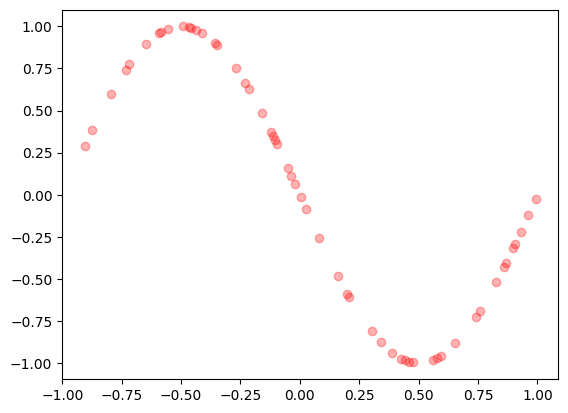

In [ ]:
ind = labeled_X[:, 1] == 0.0
print(f"Number of Datapoints with with t = 0 is {len(labeled_X[labeled_X[:, 1] == 0.0])}")
plt.scatter(labeled_X[ind][:, 0], labeled_y[ind], color = 'red', marker = "o", alpha = 0.3)

In [22]:
ind = np.abs(labeled_X[:, 0]) == 1.0
print(f"Number of Datapoints with with |x| = 1 is {len(labeled_X[np.abs(labeled_X[:, 0]) == 1.0])}")
np.max(labeled_y[ind]), np.min(labeled_y[ind]), np.mean(labeled_y[ind])

Number of Datapoints with with |x| = 1 is 46


(np.float64(2.326502818752141e-16),
 np.float64(-1.0854441803149965e-16),
 np.float64(8.236830416577723e-17))

In [ ]:
def sum(a,b):
#  a=set(range(1,100))
#  b=set(range(1,100))
 
#  c = a|b
#  return c
 

# c=sum(2,5)
# print(c) 

#  c=a+b
#  return c,a,b


# total_sum,number_1,number_2=sum(2,3)
# print("sum=" ,c, "number_1=", a, "number_2=" , b)




# print(sum=c)

sum= 5 number_1= 2 number_2= 3


In [23]:


def f(x, t):
  x = jnp.hstack([x, t])
  net = hk.nets.MLP(output_sizes = [20, 20, 20, 20, 20, 20, 20, 20, 1],
                    activation = jnp.tanh)
  return net(x)

init_params, forward_fn = hk.transform(f)
rng = jax.random.PRNGKey(500)
x_init, t_init = jnp.split(labeled_X, 2, 1)
params = init_params(rng, x_init, t_init)

In [24]:
def gradient_fn(forward_fn, loss_outputs, initial_data):
  """
  This function calls the gradient function, to implement the backpropogation
  """
  boundary_data_x = initial_data['labeled_x']
  boundary_data_t = initial_data['labeled_t']

  boundary_target = initial_data['labeled_u']

  @jax.jit
  def model_loss(params, target, weights, rng, x_train, t_train):

    @functools.partial(jax.vmap, in_axes=(None, 0, 0))
    def small_loss(params, x, t):
      u = forward_fn(params, rng, x, t)
      u_x, u_t = jacrev(forward_fn, argnums=(2, 3))(params, rng, x, t)
      u_xx = jacrev(jacrev(forward_fn, argnums=2), argnums=2)(params, rng, x, t)
      con = 0.01/np.pi
      return u_t + u * u_x - con * u_xx

    u_pred = forward_fn(params, rng, boundary_data_x, boundary_data_t)
    f_pred = small_loss(params, x_train, t_train)
    loss_u = jnp.mean((u_pred - boundary_target) ** 2)
    loss_f = jnp.mean((f_pred) ** 2)

    return loss_u + loss_f

  return model_loss

In [25]:
# Tells the neural network on how to perform calculation during inference
def create_eval_fn(forward_fn, params):
  """
  Calls the function to evaluate the model
  """
  @jax.jit
  def eval_model(x, t, rng=None):

    res = forward_fn(params, rng, x, t)
    return jnp.squeeze(res)
  return eval_model

In [15]:
# !pip install deepchem
import deepchem


In [ ]:
# find -name "*.pyc" -delete


In [26]:
scheduler = optax.piecewise_constant_schedule(
    init_value=1e-2, 
    boundaries_and_scales={2500: 0.1, 5000: 0.1, 7500: 0.1})

opt = optax.chain(
    optax.clip_by_global_norm(1.00),
    optax.scale_by_adam(b1=0.9, b2=0.99),
    optax.scale_by_schedule(scheduler),
    optax.scale(-1.0))
labeled_x, labeled_t = jnp.split(labeled_X, 2, 1)

boundary_data = {
    'labeled_x': labeled_x, 'labeled_t':labeled_t, 'labeled_u': labeled_y
}

j_m = PINNModel(      
    forward_fn = forward_fn,
    params = params,
    initial_data = boundary_data,
    batch_size = 1000,
    optimizer = opt,
    grad_fn = gradient_fn,
    eval_fn = create_eval_fn,
    deterministic = True,
    log_frequency = 1000
    )
dataset = dc.data.NumpyDataset(unlabeled_X)
val = j_m.fit(dataset, nb_epochs=500)

c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\deepchem\models\jax_models\pinns_model.py:154: UserWarning: PinnModel is still in active development and we could change the design of the API in the future.
  warnings.warn(
c:\Users\Manju\Documents\python\envs\myenv\lib\site-packages\deepchem\models\jax_models\jax_model.py:156: UserWarning: JaxModel is still in active development and all features may not yet be implemented
  warnings.warn(


In [27]:
test_dataset = dc.data.NumpyDataset(full_domain)
u_pred = j_m.predict(test_dataset)
U_pred = griddata(full_domain, u_pred.flatten(), meshgrid, method='cubic')
Error = np.abs(Exact - U_pred)

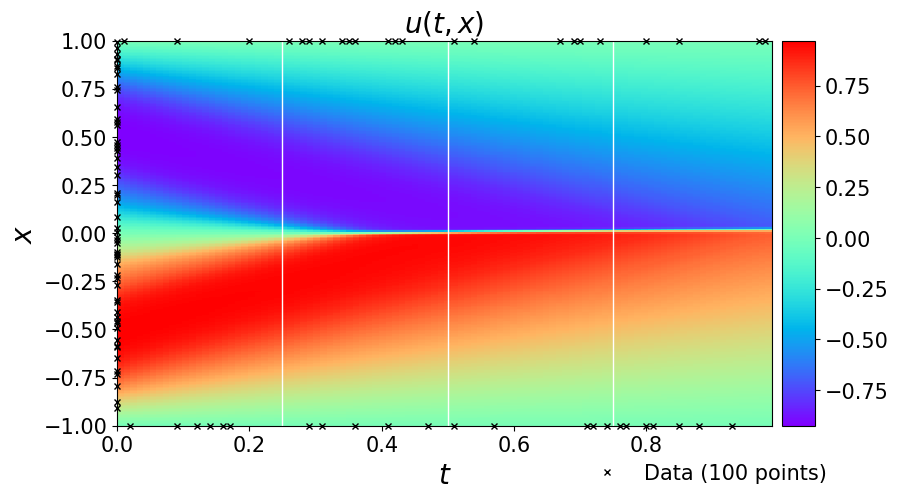

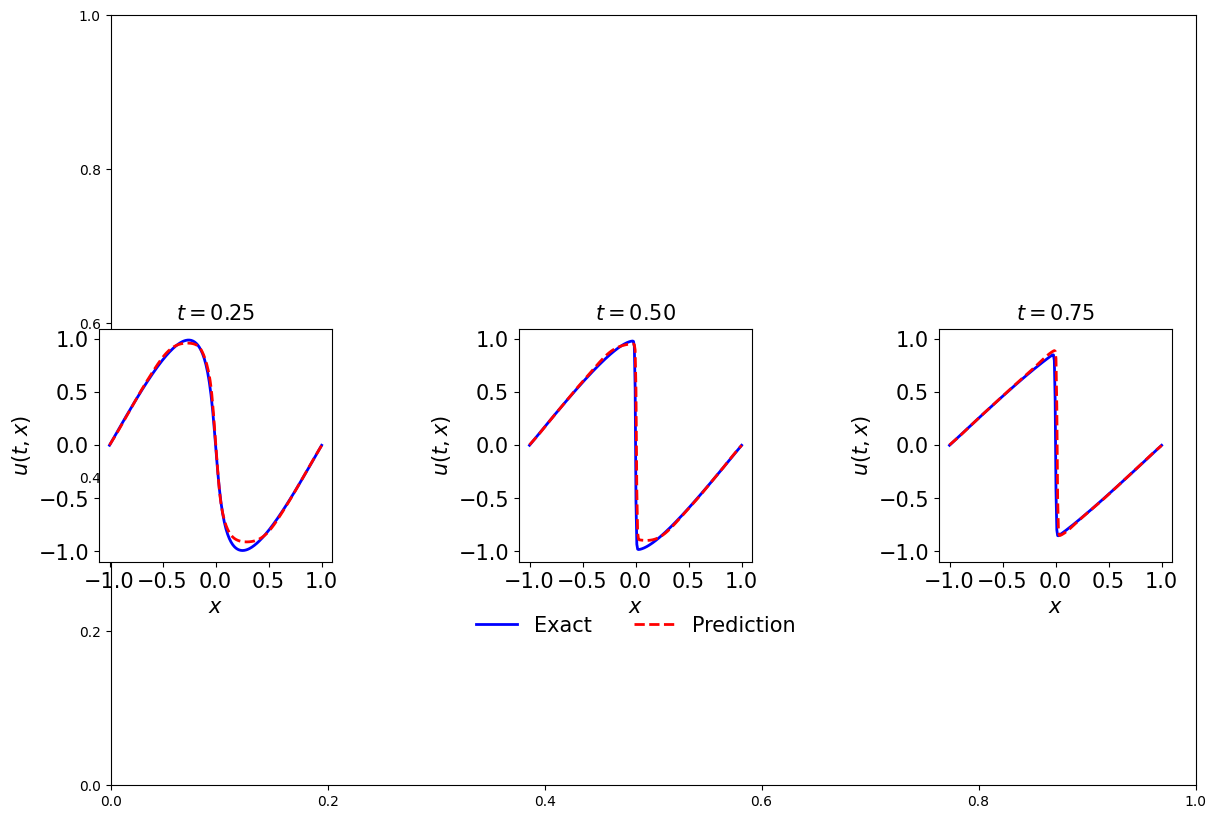

In [28]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    labeled_X[:,1], 
    labeled_X[:,0], 
    'kx', label = 'Data (%d points)' % (labeled_y.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()